In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

sns.set(style='whitegrid')
plt.style.use("seaborn-v0_8")


In [2]:
tsla_raw = pd.read_csv('tsla.csv')
bnd_raw = pd.read_csv('bnd.csv')
spy_raw = pd.read_csv('spy.csv')

tsla_raw.head()


,Date,Close,High,Low,Open,Volume
0,NaN,TSLA,TSLA,TSLA,TSLA,TSLA
1,2015-07-01,17.94333267211914,18.174667358398438,17.856666564941406,18.073999404907227,31518000
2,2015-07-02,18.667999267578125,18.829999923706055,18.220666885375977,18.68000030517578,107458500
3,2015-07-06,18.648000717163086,18.779333114624023,18.420000076293945,18.591999053955078,61828500
4,2015-07-07,17.858667373657227,18.34666633605957,17.384666442871094,18.333332061767578,91576500


In [10]:
def preprocess(df, name):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    df = df[~df.index.duplicated(keep='first')]

    # Force numeric conversion on price columns
    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in price_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # force conversion, coerce errors

    df.columns = [f"{col}_{name}" for col in df.columns]
    return df


In [11]:
tsla = preprocess(tsla_raw.copy(), "TSLA")
bnd = preprocess(bnd_raw.copy(), "BND")
spy = preprocess(spy_raw.copy(), "SPY")


In [12]:
combined = pd.concat([tsla, bnd, spy], axis=1, join='inner')
combined.to_csv('combined_cleaned.csv')

combined.head()


,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA,Close_BND,High_BND,Low_BND,Open_BND,Volume_BND,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY
Date,,,,,,,,,,,,,,,
2015-07-01,17.943333,18.174667,17.856667,18.073999,31518000.0,60.816715,60.914441,60.764093,60.794164,5399300.0,174.917099,175.363874,174.124701,175.110979,135979900.0
2015-07-02,18.667999,18.830000,18.220667,18.680000,107458500.0,60.967098,61.027240,60.937027,60.937027,1060100.0,174.756912,175.566173,174.335425,175.397581,104373700.0
2015-07-06,18.648001,18.779333,18.420000,18.591999,61828500.0,61.177578,61.222687,61.057301,61.222687,2210700.0,174.259598,175.043557,173.256457,173.458775,117975400.0
2015-07-07,17.858667,18.346666,17.384666,18.333332,91576500.0,61.237728,61.470769,61.237728,61.410634,4183200.0,175.355484,175.481925,172.059452,174.461933,173820200.0
2015-07-08,16.997334,17.386667,16.954000,17.288000,93316500.0,61.410606,61.463229,61.312875,61.373017,1967800.0,172.413483,174.293311,172.177451,174.006703,164020100.0


In [16]:
combined = pd.concat([tsla, bnd, spy], axis=1, join='inner')
combined.dropna(inplace=True)  # Clean up 1-row NaNs
combined.to_csv('combined_cleaned.csv')


In [17]:
combined.isnull().sum()


,0
Close_TSLA,0
High_TSLA,0
Low_TSLA,0
Open_TSLA,0
Volume_TSLA,0
Close_BND,0
High_BND,0
Low_BND,0
Open_BND,0
Volume_BND,0


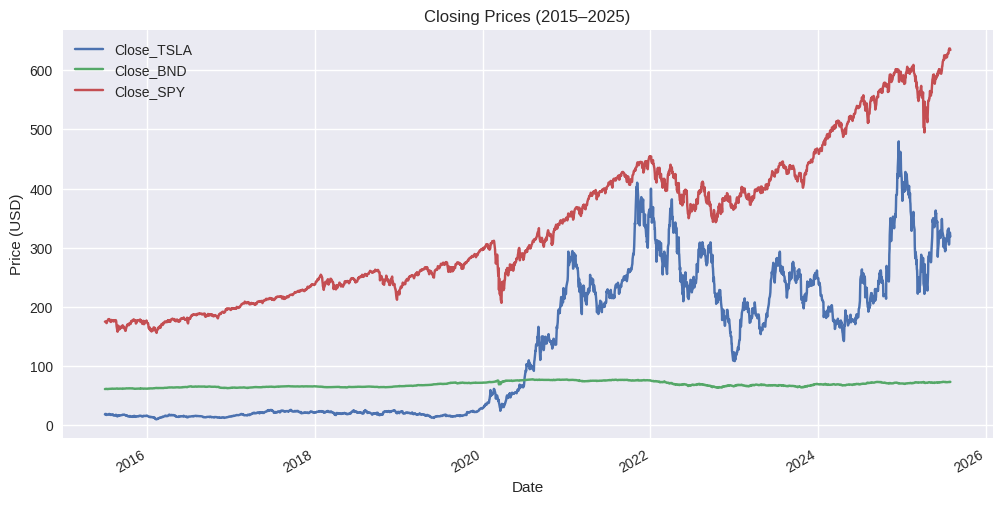

In [14]:
combined[['Close_TSLA', 'Close_BND', 'Close_SPY']].plot(title='Closing Prices (2015–2025)', figsize=(12,6))
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.show()


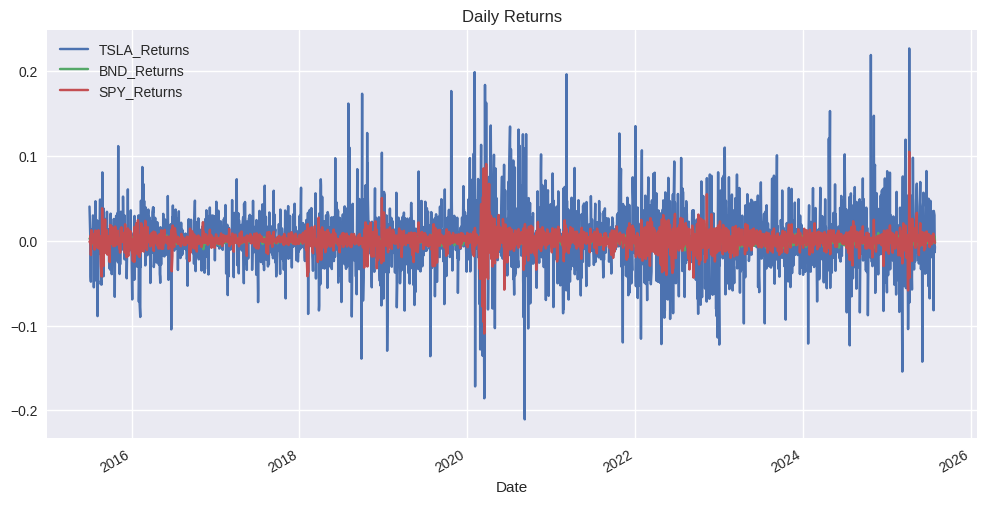

In [18]:
returns = combined[['Close_TSLA', 'Close_BND', 'Close_SPY']].pct_change().dropna()
returns.columns = ['TSLA_Returns', 'BND_Returns', 'SPY_Returns']
returns.to_csv('daily_returns.csv')

returns.plot(title="Daily Returns", figsize=(12,6))
plt.show()


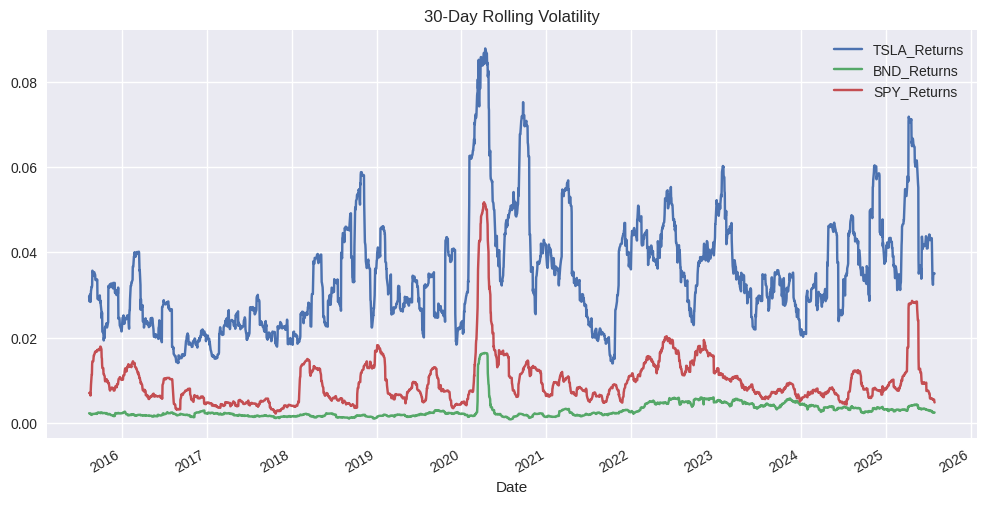

In [19]:
rolling_vol = returns.rolling(window=30).std()
rolling_vol.plot(title="30-Day Rolling Volatility", figsize=(12,6))
plt.show()


In [20]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("✅ Likely Stationary")
    else:
        print("⚠️ Likely Non-Stationary")

# Run ADF tests
adf_test(combined['Close_TSLA'], 'TSLA Price')
adf_test(returns['TSLA_Returns'], 'TSLA Returns')


ADF Test for TSLA Price:
ADF Statistic: -1.418872005396829
p-value: 0.5731959514207214
⚠️ Likely Non-Stationary
ADF Test for TSLA Returns:
ADF Statistic: -34.68109047254189
p-value: 0.0
✅ Likely Stationary


In [21]:
returns.describe().to_csv("returns_summary.csv")
